# Robyn: Marketing Mix Modeling Application

This notebook demonstrates the usage of Robyn, a Marketing Mix Modeling (MMM) application. 
We'll go through the main steps of performing robyn_inputs and robyn_engineering.



## 1. Import Required Libraries. Define Paths.

First, be sure to setup your virtual environment. Be sure to switch over to your new environment in this notebook. 

-```cd {root_folder}```

-```python3 -m yourvenv```

-```source yourvenv/bin/activate```

-```cd Robyn/python```

-```pip install -r requirements.txt```


Then import the necessary libraries. Make sure to define your paths below.



In [1]:
import sys

# Add Robyn to path
sys.path.append("/Users/yijuilee/robynpy_release_reviews/Robyn/python/src")

In [2]:
import os
import numpy as np
import pandas as pd
import pyreadr
from typing import Dict, Any
from robyn.data.entities.mmmdata import MMMData
from robyn.data.entities.enums import AdstockType
from robyn.data.entities.holidays_data import HolidaysData
from robyn.data.entities.hyperparameters import Hyperparameters, ChannelHyperparameters
from robyn.modeling.entities.modelrun_trials_config import TrialsConfig
from robyn.modeling.model_executor import ModelExecutor
from robyn.modeling.entities.enums import NevergradAlgorithm, Models
from robyn.modeling.feature_engineering import FeatureEngineering

/Users/yijuilee/robynpy_release_reviews/robynvenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2.1 Load Mock R data

We need to set the base path for the data directory.
Create a .env file in the same directory as your notebook and put in define the path to the data dir.
for example: ROBYN_BASE_PATH=.../Robyn/R/data

In [3]:
# Read the simulated data and holidays data
dt_simulated_weekly = pd.read_csv("resources/dt_simulated_weekly.csv")

print("Simulated Data...")
dt_simulated_weekly.head()

dt_prophet_holidays = pd.read_csv("resources/dt_prophet_holidays.csv")

print("Holidays Data...")
dt_prophet_holidays.head()

Simulated Data...
Holidays Data...


,ds,holiday,country,year
0,1995-01-01,New Year's Day,AD,1995
1,1995-01-06,Epiphany,AD,1995
2,1995-02-28,Carnival,AD,1995
3,1995-03-14,Constitution Day,AD,1995
4,1995-04-14,Good Friday,AD,1995


## Setup MMM Data

We will now set up the MMM data specification which includes defining the dependent variable, independent variables, and the time window for analysis.

In [4]:
def setup_mmm_data(dt_simulated_weekly) -> MMMData:

    mmm_data_spec = MMMData.MMMDataSpec(
        dep_var="revenue",
        dep_var_type="revenue",
        date_var="DATE",
        context_vars=["competitor_sales_B", "events"],
        paid_media_spends=["tv_S", "ooh_S", "print_S", "facebook_S", "search_S"],
        paid_media_vars=["tv_S", "ooh_S", "print_S", "facebook_I", "search_clicks_P"],
        organic_vars=["newsletter"],
        window_start="2016-01-01",
        window_end="2018-12-31",
    )

    return MMMData(data=dt_simulated_weekly, mmmdata_spec=mmm_data_spec)


mmm_data = setup_mmm_data(dt_simulated_weekly)
mmm_data.data.head()

,DATE,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter
0,2015-11-23,2.754372e+06,22358.346667,0.0,12728.488889,2.430128e+07,0.000000,0.000000,8125009,7607.132915,na,19401.653846
1,2015-11-30,2.584277e+06,28613.453333,0.0,0.000000,5.527033e+06,9837.238486,4133.333333,7901549,1141.952450,na,14791.000000
2,2015-12-07,2.547387e+06,0.000000,132278.4,453.866667,1.665159e+07,12044.119653,3786.666667,8300197,4256.375378,na,14544.000000
3,2015-12-14,2.875220e+06,83450.306667,0.0,17680.000000,1.054977e+07,12268.070319,4253.333333,8122883,2800.490677,na,2800.000000
4,2015-12-21,2.215953e+06,0.000000,277336.0,0.000000,2.934090e+06,9467.248023,3613.333333,7105985,689.582605,na,15478.000000


## Feature Preprocessing

We will perform feature engineering to prepare the data for modeling. This includes transformations like adstock and other preprocessing steps.

In [5]:
hyperparameters = Hyperparameters(
    {
        "facebook_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0, 0.3],
        ),
        "print_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
        "tv_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.3, 0.8],
        ),
        "search_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0, 0.3],
        ),
        "ooh_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
        "newsletter": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
    },
    adstock=AdstockType.GEOMETRIC,
    lambda_=0.0,
    train_size=[0.5, 0.8],
)

print("Hyperparameters setup complete.")

Hyperparameters setup complete.


In [6]:
# Create HolidaysData object
holidays_data = HolidaysData(
    dt_holidays=dt_prophet_holidays,
    prophet_vars=["trend", "season", "holiday"],
    prophet_country="DE",
    prophet_signs=["default", "default", "default"],
)
# Setup FeaturizedMMMData
feature_engineering = FeatureEngineering(mmm_data, hyperparameters, holidays_data)

In [7]:
featurized_mmm_data = feature_engineering.perform_feature_engineering()

03:52:37 - cmdstanpy - INFO - Chain [1] start processing
2024-11-07 03:52:37 - cmdstanpy - INFO - Chain [1] start processing
03:52:37 - cmdstanpy - INFO - Chain [1] done processing
2024-11-07 03:52:37 - cmdstanpy - INFO - Chain [1] done processing
2024-11-07 03:52:37 - robyn.modeling.feature_engineering - INFO - Prophet decomposition complete.
2024-11-07 03:52:37 - robyn.modeling.feature_engineering - INFO - Processing tv_S
2024-11-07 03:52:37 - robyn.modeling.feature_engineering - INFO - Processing ooh_S
2024-11-07 03:52:38 - robyn.modeling.feature_engineering - INFO - Processing print_S
2024-11-07 03:52:40 - robyn.modeling.feature_engineering - INFO - Processing facebook_S
2024-11-07 03:52:40 - robyn.modeling.feature_engineering - INFO - Processing search_S
2024-11-07 03:52:40 - robyn.modeling.feature_engineering - INFO - Feature engineering complete.
/Users/yijuilee/robynpy_release_reviews/Robyn/python/src/robyn/modeling/feature_engineering.py:123: FutureWarning: DataFrame.fillna wi

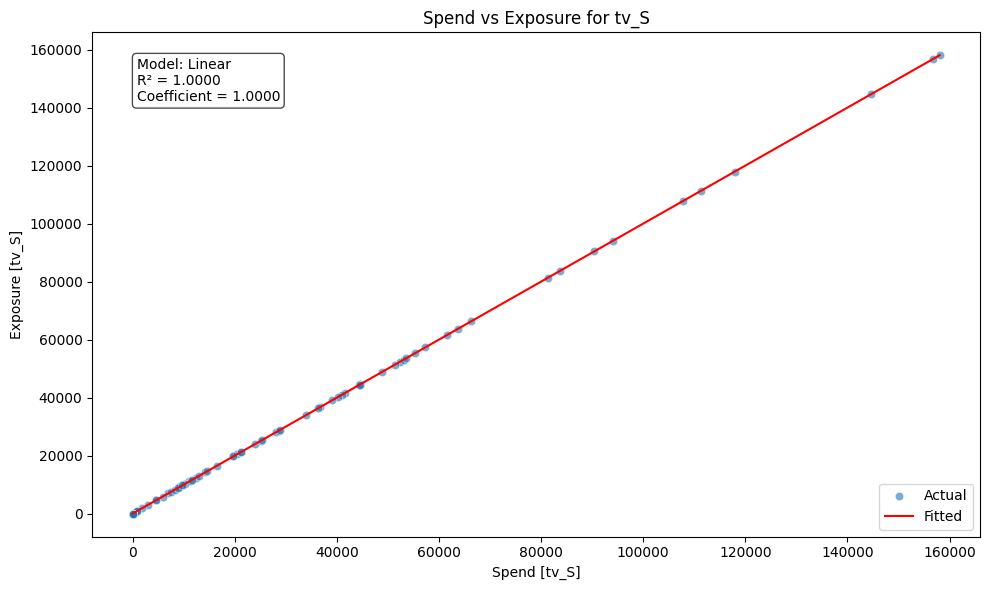

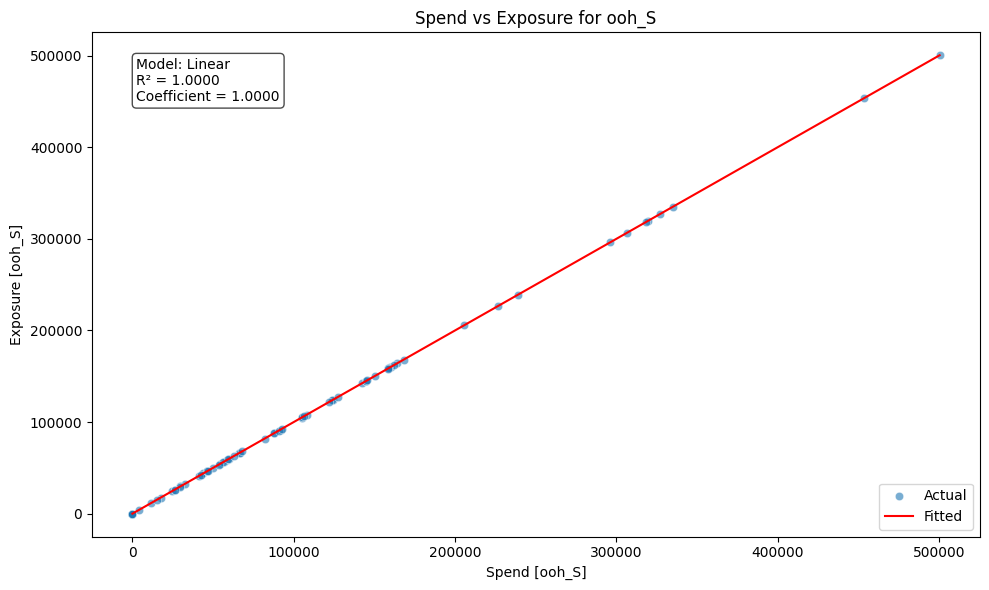

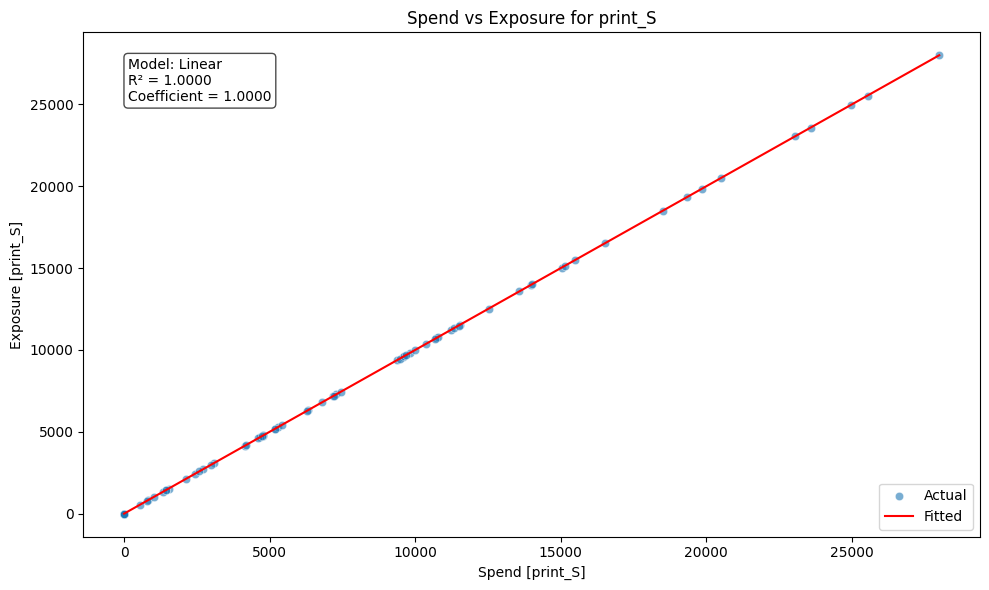

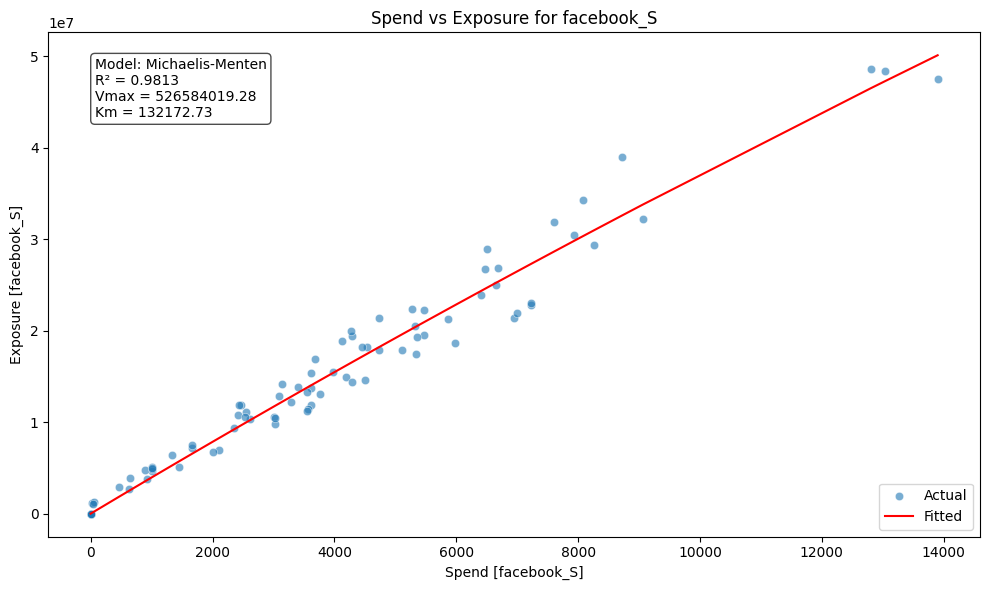

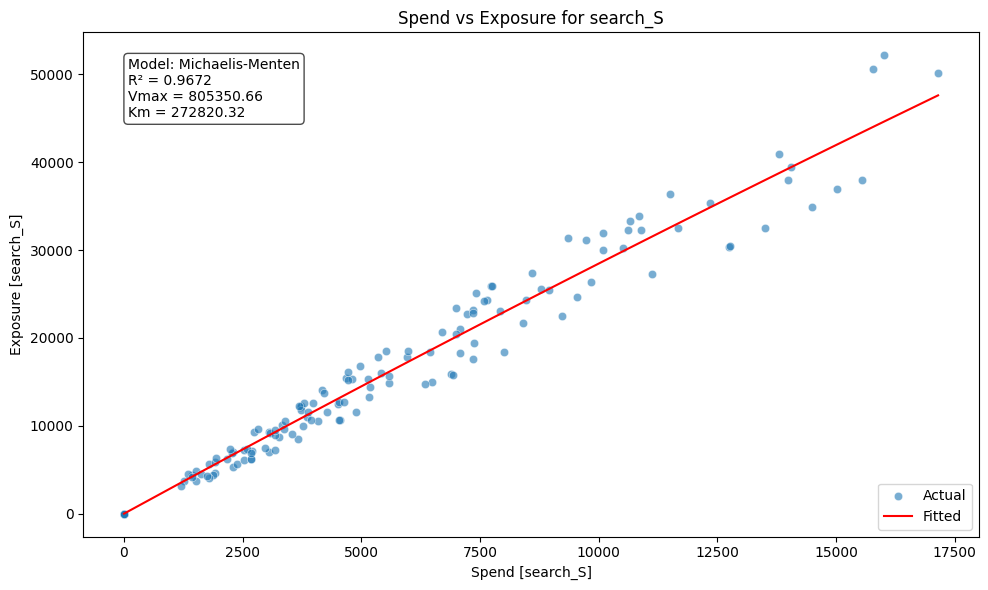

In [8]:
from robyn.visualization.feature_visualization import FeaturePlotter
import matplotlib.pyplot as plt

# Create a FeaturePlotter instance
feature_plotter = FeaturePlotter(mmm_data, hyperparameters)

# Plot spend-exposure relationship for each channel
for channel in mmm_data.mmmdata_spec.paid_media_spends:
    try:
        fig = feature_plotter.plot_spend_exposure(featurized_mmm_data, channel)
        plt.show()
    except ValueError as e:
        print(f"Skipping {channel}: {str(e)}")

2024-11-07 03:52:41 - robyn.modeling.ridge_model_builder - INFO - Collecting hyperparameters for optimization... {'prepared_hyperparameters': Hyperparameters(hyperparameters={'facebook_S': ChannelHyperparameters(thetas=[0, 0.3], shapes=None, scales=None, alphas=[0.5, 3], gammas=[0.3, 1], penalty=None), 'print_S': ChannelHyperparameters(thetas=[0.1, 0.4], shapes=None, scales=None, alphas=[0.5, 3], gammas=[0.3, 1], penalty=None), 'tv_S': ChannelHyperparameters(thetas=[0.3, 0.8], shapes=None, scales=None, alphas=[0.5, 3], gammas=[0.3, 1], penalty=None), 'search_S': ChannelHyperparameters(thetas=[0, 0.3], shapes=None, scales=None, alphas=[0.5, 3], gammas=[0.3, 1], penalty=None), 'ooh_S': ChannelHyperparameters(thetas=[0.1, 0.4], shapes=None, scales=None, alphas=[0.5, 3], gammas=[0.3, 1], penalty=None), 'newsletter': ChannelHyperparameters(thetas=[0.1, 0.4], shapes=None, scales=None, alphas=[0.5, 3], gammas=[0.3, 1], penalty=None)}, adstock=<AdstockType.GEOMETRIC: 'geometric'>, lambda_=0.0,

>>> Starting 5 trials with 2000 iterations each using TwoPointsDE nevergrad algorithm on x cores...


Running trial 1 of total 5 trials: 100%|███████████████████████████████████
2024-11-07 03:54:38 - robyn.modeling.ridge_model_builder - INFO -  Finished in 1.95 mins
Running trial 2 of total 5 trials: 100%|███████████████████████████████████
2024-11-07 03:56:30 - robyn.modeling.ridge_model_builder - INFO -  Finished in 1.87 mins
Running trial 3 of total 5 trials: 100%|███████████████████████████████████
2024-11-07 03:58:20 - robyn.modeling.ridge_model_builder - INFO -  Finished in 1.81 mins
Running trial 4 of total 5 trials: 100%|███████████████████████████████████
2024-11-07 04:00:09 - robyn.modeling.ridge_model_builder - INFO -  Finished in 1.82 mins
Running trial 5 of total 5 trials: 100%|███████████████████████████████████
2024-11-07 04:01:59 - robyn.modeling.ridge_model_builder - INFO -  Finished in 1.81 mins
2024-11-07 04:02:00 - robyn.modeling.convergence.convergence - INFO - Starting convergence calculation
2024-11-07 04:02:00 - robyn.modeling.convergence.convergence - WARNING -

Model training complete.


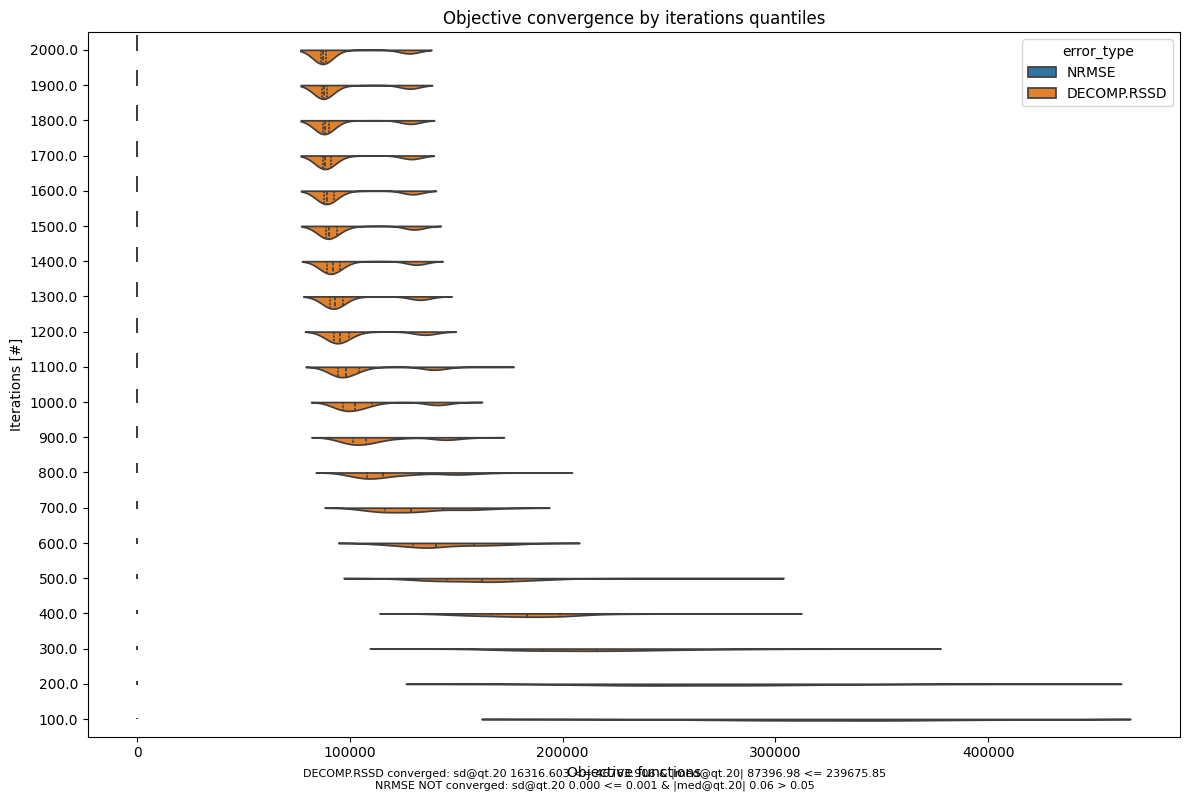

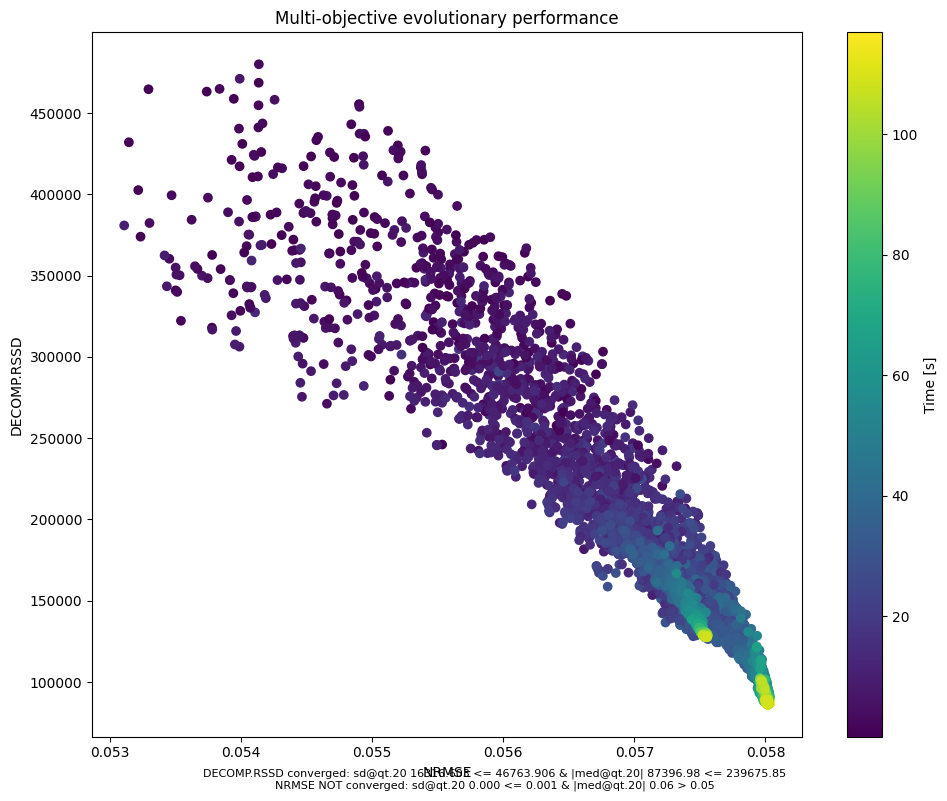

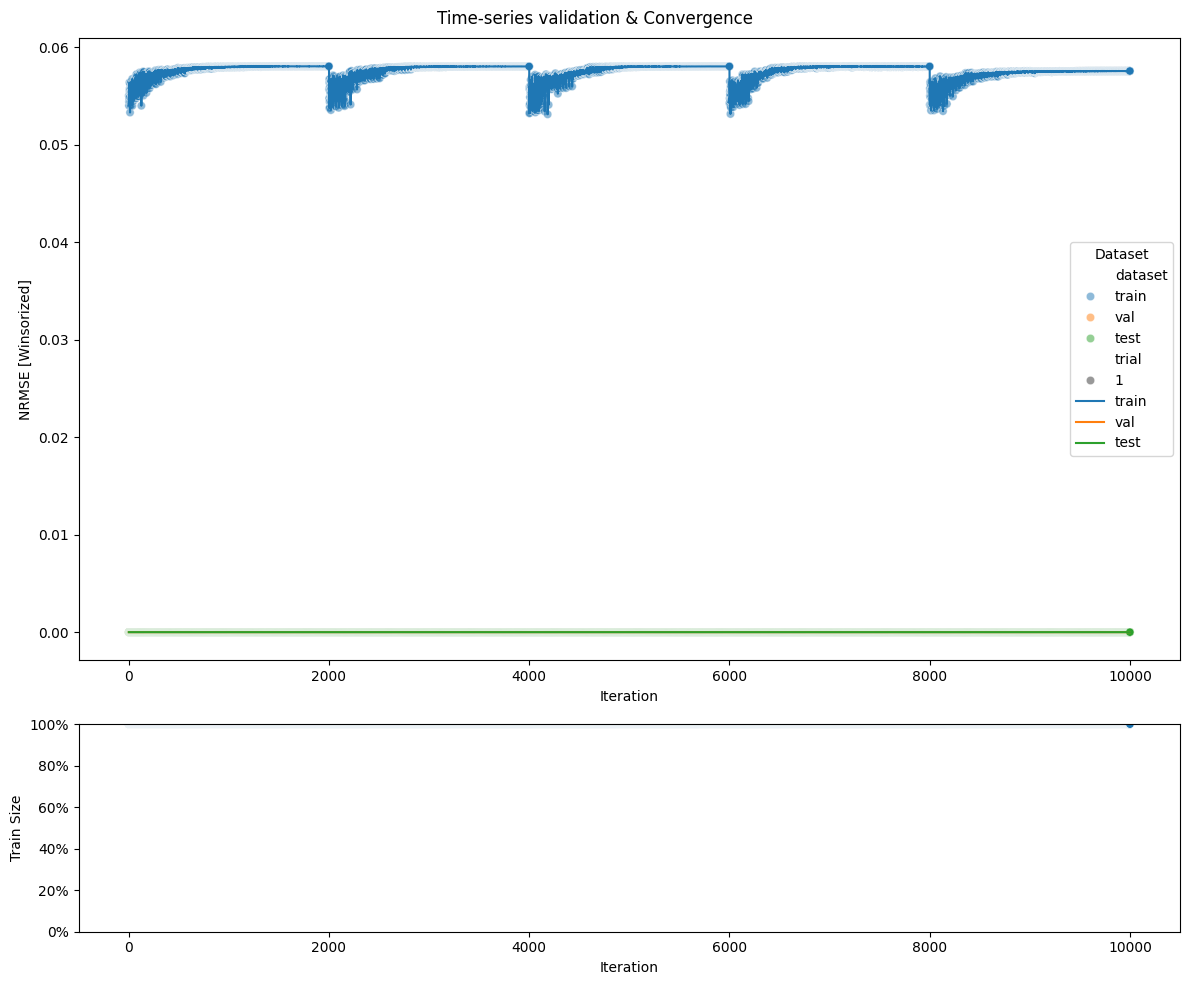

In [9]:
# Setup ModelExecutor
model_executor = ModelExecutor(
    mmmdata=mmm_data,
    holidays_data=holidays_data,
    hyperparameters=hyperparameters,
    calibration_input=None,  # Add calibration input if available
    featurized_mmm_data=featurized_mmm_data,
)

# Setup TrialsConfig
trials_config = TrialsConfig(iterations=2000, trials=5)  # Set to the number of cores you want to use

print(
    f">>> Starting {trials_config.trials} trials with {trials_config.iterations} iterations each using {NevergradAlgorithm.TWO_POINTS_DE.value} nevergrad algorithm on x cores..."
)

# Run the model

output_models = model_executor.model_run(
    trials_config=trials_config,
    ts_validation=False,  # changed from True to False -> deacitvate
    add_penalty_factor=False,
    rssd_zero_penalty=True,
    cores=8,
    nevergrad_algo=NevergradAlgorithm.TWO_POINTS_DE,
    intercept=True,
    intercept_sign="non_negative",
    model_name=Models.RIDGE,
)
print("Model training complete.")

# TODO fix graph outputs

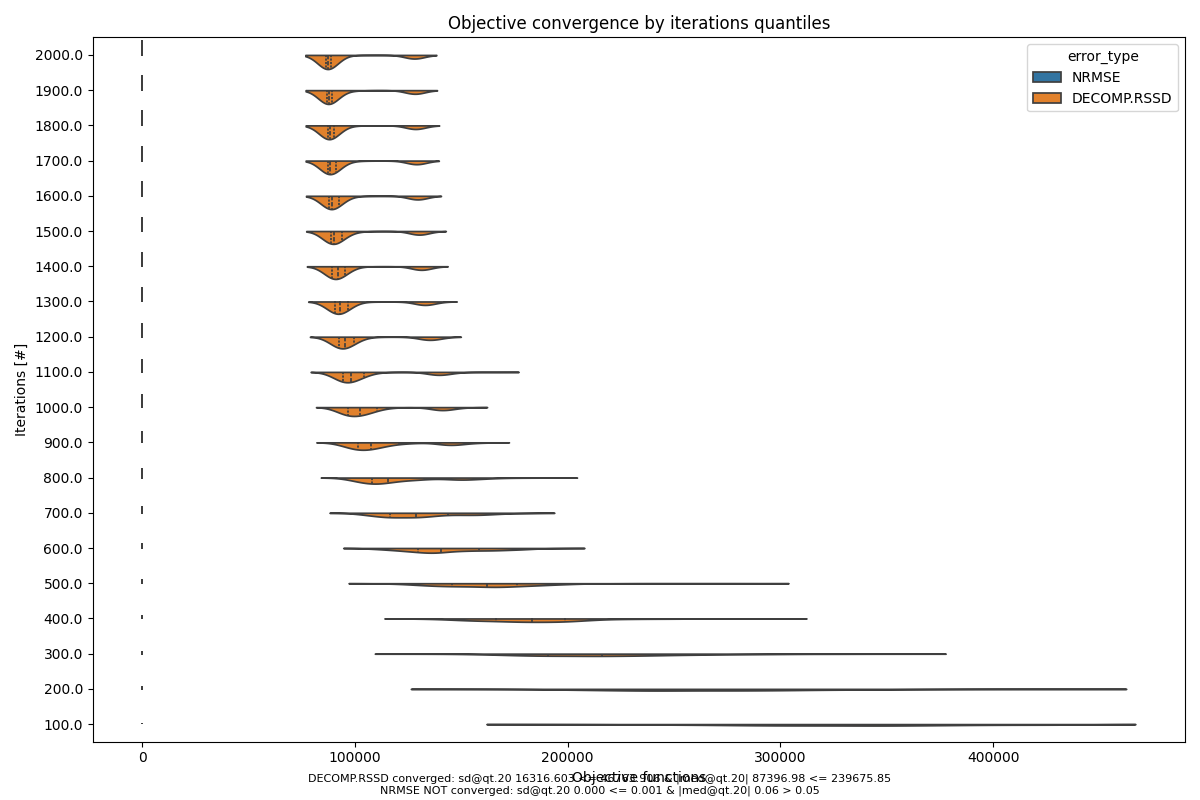

In [10]:
from IPython.display import Image, display
import base64
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# 1. Display the MOO Distribution Plot
if "moo_distrb_plot" in output_models.convergence:
    moo_distrb_plot = output_models.convergence["moo_distrb_plot"]
    display(Image(data=base64.b64decode(moo_distrb_plot)))

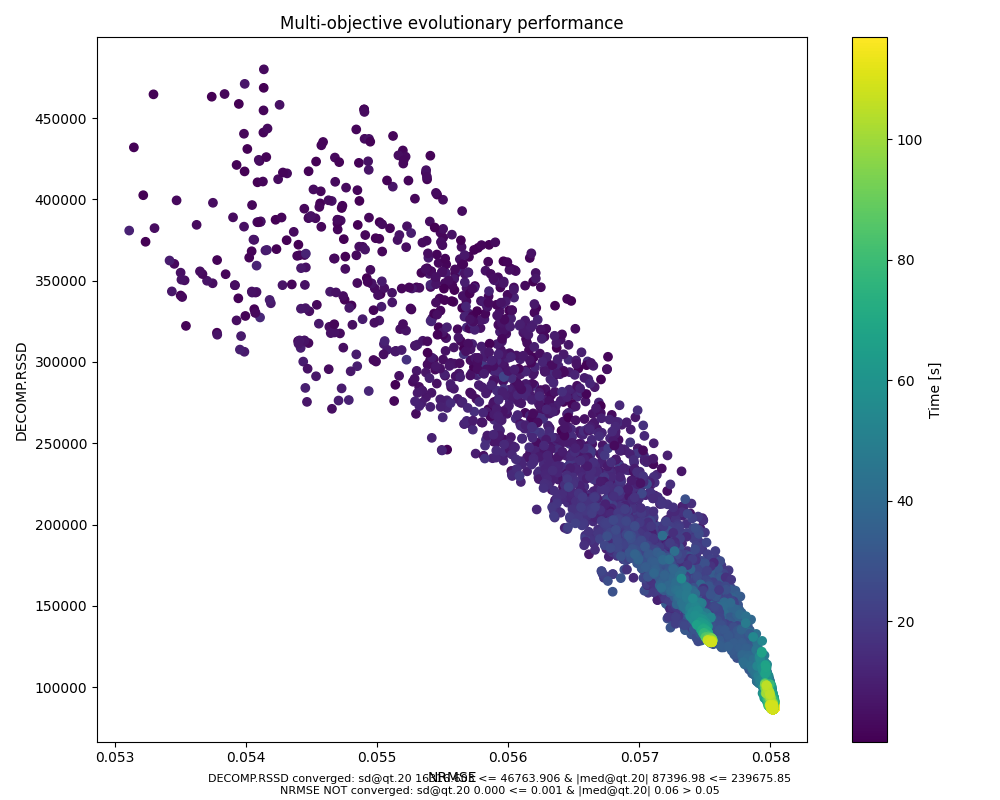

In [11]:
# 2. Display the MOO Cloud Plot
if "moo_cloud_plot" in output_models.convergence:
    moo_cloud_plot = output_models.convergence["moo_cloud_plot"]
    display(Image(data=base64.b64decode(moo_cloud_plot)))

In [12]:
# 3. Print convergence messages
if "conv_msg" in output_models.convergence:
    for msg in output_models.convergence["conv_msg"]:
        print(msg)

DECOMP.RSSD converged: sd@qt.20 16316.603 <= 46763.906 & |med@qt.20| 87396.98 <= 239675.85
NRMSE NOT converged: sd@qt.20 0.000 <= 0.001 & |med@qt.20| 0.06 > 0.05


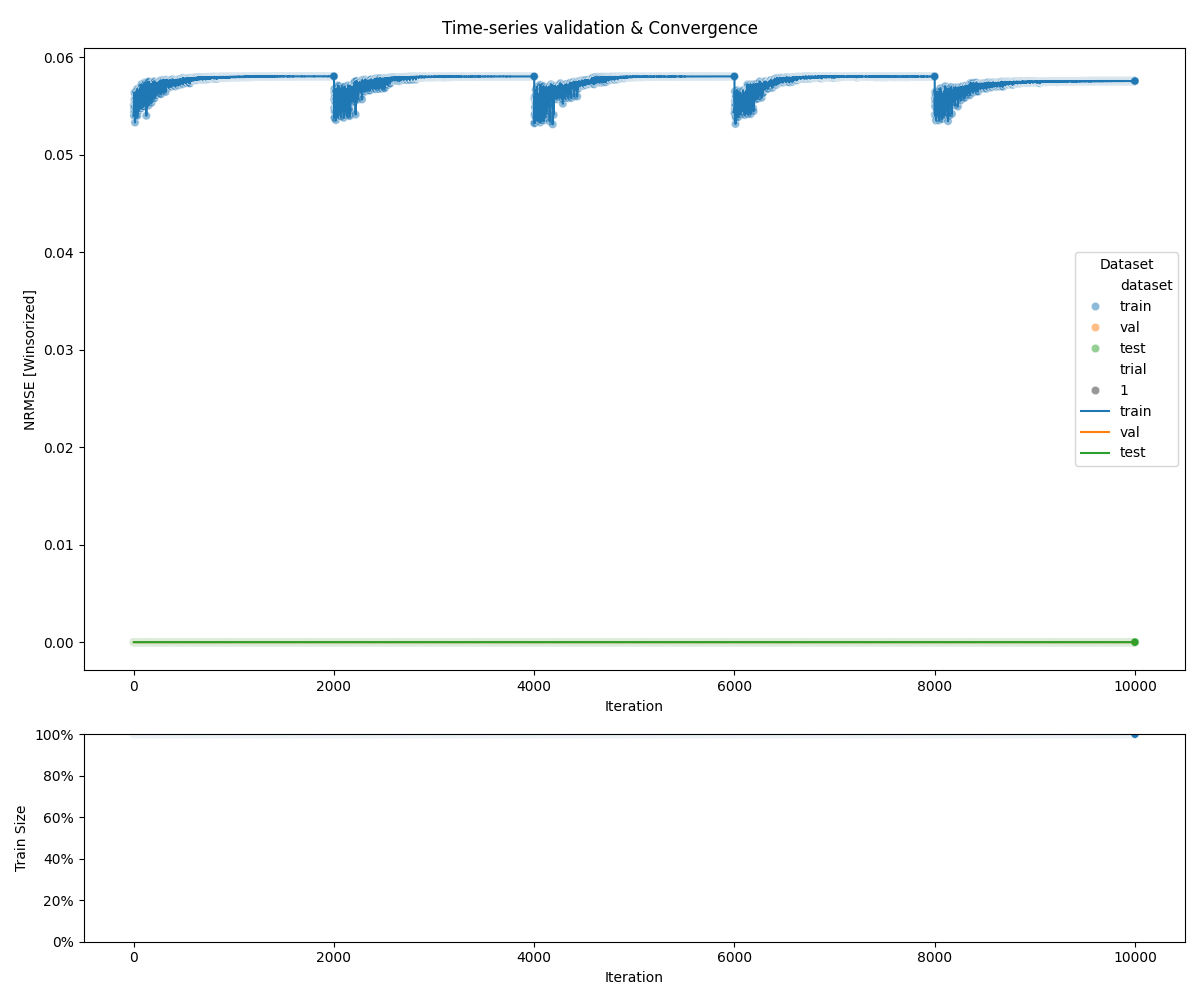

In [13]:
# 4. Display time series validation and convergence plots
if "ts_validation_plot" in output_models.convergence:
    ts_validation_plot = output_models.convergence["ts_validation_plot"]
    display(Image(data=base64.b64decode(ts_validation_plot)))

In [14]:
best_model_id = output_models.select_id
print(f"Best model ID: {best_model_id}")

Best model ID: 2_1962_1


In [21]:
import pandas as pd
import json
from typing import Dict, Any, List
import numpy as np

from datetime import datetime, timedelta
from robyn.data.entities.mmmdata import MMMData
from robyn.modeling.entities.modeloutputs import ModelOutputs, Trial
from robyn.modeling.pareto.pareto_optimizer import ParetoOptimizer
from robyn.data.entities.enums import DependentVarType, PaidMediaSigns, OrganicSigns, ContextSigns
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
# 3. Create ParetoOptimizer instance
pareto_optimizer = ParetoOptimizer(mmm_data, output_models, hyperparameters, featurized_mmm_data, holidays_data)

In [ ]:
# 4. Run optimize function
pareto_result = pareto_optimizer.optimize(pareto_fronts="auto", min_candidates=100)


Columns in result_hyp_param: ['facebook_S_thetas', 'facebook_S_alphas', 'facebook_S_gammas', 'print_S_thetas', 'print_S_alphas', 'print_S_gammas', 'tv_S_thetas', 'tv_S_alphas', 'tv_S_gammas', 'search_S_thetas', 'search_S_alphas', 'search_S_gammas', 'ooh_S_thetas', 'ooh_S_alphas', 'ooh_S_gammas', 'newsletter_thetas', 'newsletter_alphas', 'newsletter_gammas', 'train_size', 'rsq_train', 'rsq_val', 'rsq_test', 'nrmse_train', 'nrmse_val', 'nrmse_test', 'nrmse', 'decomp.rssd', 'mape', 'lambda', 'solID', 'trial', 'iterNG', 'iterPar', 'ElapsedAccum', 'iterations', 'coef', 'mape.qt10', 'robynPareto', 'error_score']
Found decomp_spend_dist in trial with shape: (10000, 34)
Found decomp_spend_dist in trial with shape: (10000, 34)
Found decomp_spend_dist in trial with shape: (10000, 34)
Found decomp_spend_dist in trial with shape: (10000, 34)
Found decomp_spend_dist in trial with shape: (10000, 34)

Concatenated decomp_spend_dist shape: (50000, 34)

Columns in decomp_spend_dist: ['rn', 'coef', 'xD

Processing Solutions: 100%|██████████| 103/103 [00:00<00:00, 796.21solution/s]


Number of Pareto solutions found: 103


In [57]:
# 5. Check results
print("Pareto Optimization Results:")
print(f"Number of Pareto fronts: {pareto_result.pareto_solutions}")
print(f"MediaVecCollect: {pareto_result.media_vec_collect.shape, pareto_result.media_vec_collect}")
print("\Hyper parameter solutions:")
print(pareto_result.result_hyp_param)

print("\nAggregated decomposition results:")
print(pareto_result.x_decomp_agg)
print("\result Calibration:")
print(pareto_result.result_calibration)
print("\nx Decomp Vec Collect:")
print(pareto_result.x_decomp_vec_collect.shape, pareto_result.x_decomp_vec_collect)
print("\nCarryover percentage all:")
print(pareto_result.df_caov_pct_all.shape, pareto_result.df_caov_pct_all)
print("\Plot Data Collected")
# print("NUMBER OF PLOTS Data collected for:", len(pareto_result.plot_data_collect["5_221_9"]))
# print("Plot data for solid 5_221_9", pareto_result.plot_data_collect["5_221_9"])

# 6. Validate logic
assert pareto_result.pareto_fronts == "auto" or isinstance(
    pareto_result.pareto_fronts, int
), "Invalid pareto_fronts value"
assert not pareto_result.result_hyp_param.empty, "Empty result_hyp_param DataFrame"
assert not pareto_result.x_decomp_agg.empty, "Empty x_decomp_agg DataFrame"

print("\nAll assertions passed. The optimize function is working as expected.")

KeyboardInterrupt: 

## Allocator

In [ ]:
## Step 1: Setup and Import
import sys
import os
import pandas as pd
import numpy as np
from typing import Dict, Any, Union, List
import matplotlib.pyplot as plt

# Import necessary Robyn classes
from robyn.data.entities.mmmdata import MMMData
from robyn.modeling.entities.modeloutputs import ModelOutputs
from robyn.data.entities.hyperparameters import Hyperparameters
from robyn.allocator.entities.enums import OptimizationScenario, ConstrMode
from robyn.allocator.budget_allocator import BudgetAllocator
from robyn.modeling.pareto.pareto_optimizer import ParetoResult
from robyn.allocator.entities.allocation_config import AllocationConfig
from robyn.allocator.entities.allocation_constraints import AllocationConstraints
from robyn.visualization.allocator_plotter import AllocationPlotter
from utils.data_mapper import load_data_from_json, import_input_collect, import_output_collect, import_output_models
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
pareto_result.result_hyp_param.rename(columns={"solID": "sol_id"}, inplace=True)

In [ ]:
# Make sure to use the correct model ID from your pareto results
available_models = pareto_result.result_hyp_param["sol_id"].unique()  # or 'solID' if that's the column name
print(f"Available models: {available_models}")
# Initialize allocator with a valid model ID
select_model = available_models[0]  # Use first available model

# Initialize budget allocator
allocator = BudgetAllocator(
    mmm_data=mmm_data,
    featurized_mmm_data=featurized_mmm_data,
    model_outputs=output_models,
    pareto_result=pareto_result,  # Get ParetoResult from import_output_collect()
    select_model=select_model,
)

Available models: ['1_1_1' '1_2_1' '1_3_1' ... '5_1998_1' '5_1999_1' '5_2000_1']

Calculating media response parameters...
Using model ID: 1_1_1

Processing channel: facebook_S
Alpha: 2.833923426714773
Gamma: 0.7461767489546803
Inflexion: 11491.413993456703

Processing channel: ooh_S
Alpha: 1.1092820296034827
Gamma: 0.7675144403188092
Inflexion: 384034.7533810239

Processing channel: print_S
Alpha: 2.8344977806158678
Gamma: 0.3174903656125263
Inflexion: 10135.026225863474

Processing channel: search_S
Alpha: 2.1446409489953253
Gamma: 0.8896622623830677
Inflexion: 15907.16125140925

Processing channel: tv_S
Alpha: 1.676884920914796
Gamma: 0.6647690397809165
Inflexion: 105064.468795464


## Run Different Optimization Scenarios

### Scenario 1: Default Max Response

In [ ]:
# Create base constraints matching R example
channel_constraints = AllocationConstraints(
    channel_constr_low={
        "tv_S": 0.7,  # -30% from base
        "ooh_S": 0.7,
        "print_S": 0.7,
        "facebook_S": 0.7,
        "search_S": 0.7,
    },
    channel_constr_up={
        "tv_S": 1.2,  # +20% from base
        "ooh_S": 1.5,  # +50% from base
        "print_S": 1.5,
        "facebook_S": 1.5,
        "search_S": 1.5,
    },
    channel_constr_multiplier=3.0,
)

# Configure max response scenario
max_response_config = AllocationConfig(
    scenario=OptimizationScenario.MAX_RESPONSE,
    constraints=channel_constraints,
    date_range="last",  # Use last period as initial
    total_budget=None,  # Use historical budget
    maxeval=100000,
    optim_algo="SLSQP_AUGLAG",
    constr_mode=ConstrMode.EQUALITY,
    plots=True,
)

# Run optimization
result = allocator.allocate(max_response_config)

# Print results
print(
    f"""
Model ID: {select_model}
Scenario: {max_response_config.scenario}
Use case: {result.metrics.get('use_case', '')}
Window: {result.metrics.get('date_range_start')}:{result.metrics.get('date_range_end')} ({result.metrics.get('n_periods')} {mmm_data.mmmdata_spec.interval_type})

Dep. Variable Type: {mmm_data.mmmdata_spec.dep_var_type}
Media Skipped: {result.metrics.get('skipped_channels', 'None')}
Relative Spend Increase: {result.metrics.get('spend_lift_pct', 0):.1f}% ({result.metrics.get('spend_lift_abs', 0):+.0f}K)
Total Response Increase (Optimized): {result.metrics.get('response_lift', 0)*100:.1f}%

Allocation Summary:
"""
)

# Print channel-level results
for channel in mmm_data.mmmdata_spec.paid_media_spends:
    current = result.optimal_allocations[result.optimal_allocations["channel"] == channel].iloc[0]

    print(
        f"""
- {channel}:
  Optimizable bound: [{(current['constr_low']-1)*100:.0f}%, {(current['constr_up']-1)*100:.0f}%],
  Initial spend share: {current['current_spend_share']*100:.2f}% -> Optimized bounded: {current['optimal_spend_share']*100:.2f}%
  Initial response share: {current['current_response_share']*100:.2f}% -> Optimized bounded: {current['optimal_response_share']*100:.2f}%
  Initial abs. mean spend: {current['current_spend']/1000:.3f}K -> Optimized: {current['optimal_spend']/1000:.3f}K [Delta = {(current['optimal_spend']/current['current_spend']-1)*100:.0f}%]
"""
    )


Model ID: 1_1_1
Scenario: max_response
Use case: 
Window: 2019-11-11 00:00:00:2019-11-11 00:00:00 (1 week)

Dep. Variable Type: revenue
Media Skipped: None
Relative Spend Increase: 0.0% (+0K)
Total Response Increase (Optimized): 13.3%

Allocation Summary:


- tv_S:
  Optimizable bound: [-30%, 20%],
  Initial spend share: 7.14% -> Optimized bounded: 5.00%
  Initial response share: 0.10% -> Optimized bounded: 0.05%
  Initial abs. mean spend: 1.221K -> Optimized: 0.854K [Delta = -30%]


- ooh_S:
  Optimizable bound: [-30%, 50%],
  Initial spend share: 7.14% -> Optimized bounded: 5.00%
  Initial response share: 0.31% -> Optimized bounded: 0.18%
  Initial abs. mean spend: 1.221K -> Optimized: 0.854K [Delta = -30%]


- print_S:
  Optimizable bound: [-30%, 50%],
  Initial spend share: 7.14% -> Optimized bounded: 5.00%
  Initial response share: 0.45% -> Optimized bounded: 0.14%
  Initial abs. mean spend: 1.221K -> Optimized: 0.854K [Delta = -30%]


- facebook_S:
  Optimizable bound: [-30%, 50

/Users/yijuilee/robynpy_release_reviews/Robyn/python/src/robyn/allocator/budget_allocator.py:496: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_spend = max(optimal_spend_np[i], current_spend_np[i]) * 1.5
/Users/yijuilee/robynpy_release_reviews/Robyn/python/src/robyn/allocator/budget_allocator.py:529: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "is_current": np.isclose(spend_range[j], current_spend_np[i], rtol=1e-3),


### Scenario 3: Target Efficiency
Optimize allocation based on target ROI/CPA.

In [ ]:
### Scenario 3: Default Target Efficiency (Target ROAS or CPA)
print("\nScenario 3: Target efficiency optimization")

# Create constraints matching R's implementation
default_channel_constraints = AllocationConstraints(
    channel_constr_low={
        channel: 0.1 for channel in mmm_data.mmmdata_spec.paid_media_spends  # -90% from base for all channels
    },
    channel_constr_up={
        channel: 10.0 for channel in mmm_data.mmmdata_spec.paid_media_spends  # +900% from base for all channels
    },
    channel_constr_multiplier=1.0,  # Don't extend bounds for target efficiency
    is_target_efficiency=True,  # Flag this as target efficiency scenario
)

# Create configuration for target efficiency scenario
target_efficiency_config = AllocationConfig(
    scenario=OptimizationScenario.TARGET_EFFICIENCY,
    constraints=default_channel_constraints,
    date_range="all",  # Use all dates like in R version
    target_value=None,  # Will use default 80% of initial ROAS or 120% of initial CPA
    maxeval=100000,
    optim_algo="SLSQP_AUGLAG",
    constr_mode=ConstrMode.EQUALITY,
    plots=True,
)

# Run optimization
result3 = allocator.allocate(target_efficiency_config)

# Print results matching R format
print(
    f"""
Model ID: {select_model}
Scenario: {target_efficiency_config.scenario}
Use case: {result3.metrics.get('use_case', '')}
Window: {result3.metrics.get('date_range_start')}:{result3.metrics.get('date_range_end')} ({result3.metrics.get('n_periods')} {mmm_data.mmmdata_spec.interval_type})

Dep. Variable Type: {mmm_data.mmmdata_spec.dep_var_type}
Media Skipped: {result3.metrics.get('skipped_channels', 'None')}
Relative Spend Increase: {result3.metrics.get('spend_lift_pct', 0):.0f}% ({result3.metrics.get('spend_lift_abs', 0):.0f})
Total Response Increase (Optimized): {result3.metrics.get('response_lift', 0)*100:.0f}%

Allocation Summary:
"""
)

# Print channel-level results
for channel in mmm_data.mmmdata_spec.paid_media_spends:
    current = result3.optimal_allocations[result3.optimal_allocations["channel"] == channel].iloc[0]

    print(
        f"""
- {channel}:
  Optimizable bound: [{(current['constr_low']-1)*100:.0f}%, {(current['constr_up']-1)*100:.0f}%],
  Initial spend share: {current['current_spend_share']*100:.2f}% -> Optimized bounded: {current['optimal_spend_share']*100:.2f}%
  Initial response share: {current['current_response_share']*100:.2f}% -> Optimized bounded: {current['optimal_response_share']*100:.2f}%
  Initial abs. mean spend: {current['current_spend']/1000:.3f}K -> Optimized: {current['optimal_spend']/1000:.3f}K [Delta = {(current['optimal_spend']/current['current_spend']-1)*100:.0f}%]
"""
    )


Scenario 3: Target efficiency optimization

Model ID: 1_1_1
Scenario: target_efficiency
Use case: all_historical_vec + historical_budget
Window: 2015-11-23 00:00:00:2019-11-11 00:00:00 (208 week)

Dep. Variable Type: revenue
Media Skipped: None
Relative Spend Increase: -3% (-2)
Total Response Increase (Optimized): -22%

Allocation Summary:


- tv_S:
  Optimizable bound: [-90%, 900%],
  Initial spend share: 21.25% -> Optimized bounded: 21.91%
  Initial response share: 12.54% -> Optimized bounded: 16.17%
  Initial abs. mean spend: 14.844K -> Optimized: 14.846K [Delta = 0%]


- ooh_S:
  Optimizable bound: [-90%, 900%],
  Initial spend share: 61.87% -> Optimized bounded: 63.88%
  Initial response share: 28.20% -> Optimized bounded: 36.40%
  Initial abs. mean spend: 43.218K -> Optimized: 43.282K [Delta = 0%]


- print_S:
  Optimizable bound: [-90%, 900%],
  Initial spend share: 5.34% -> Optimized bounded: 3.98%
  Initial response share: 19.22% -> Optimized bounded: 10.25%
  Initial abs. me

Max Response Scenario Plots:
--------------------------------------------------


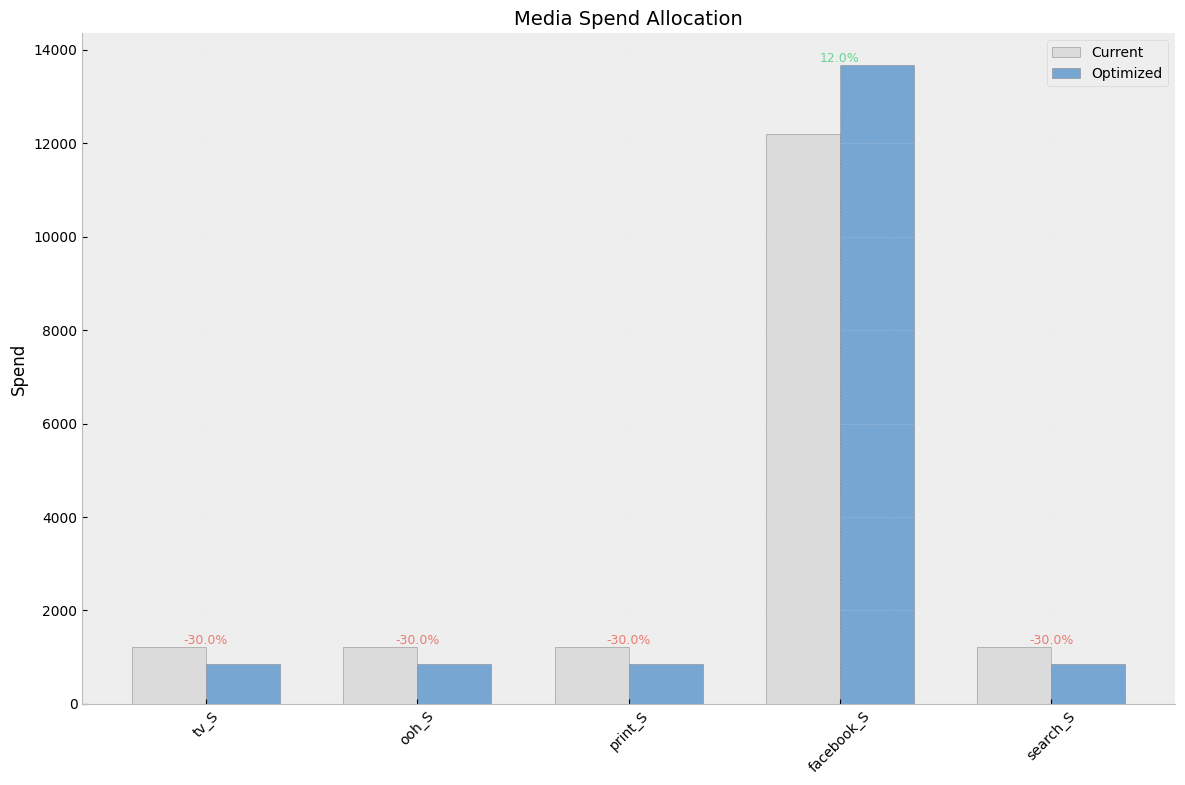

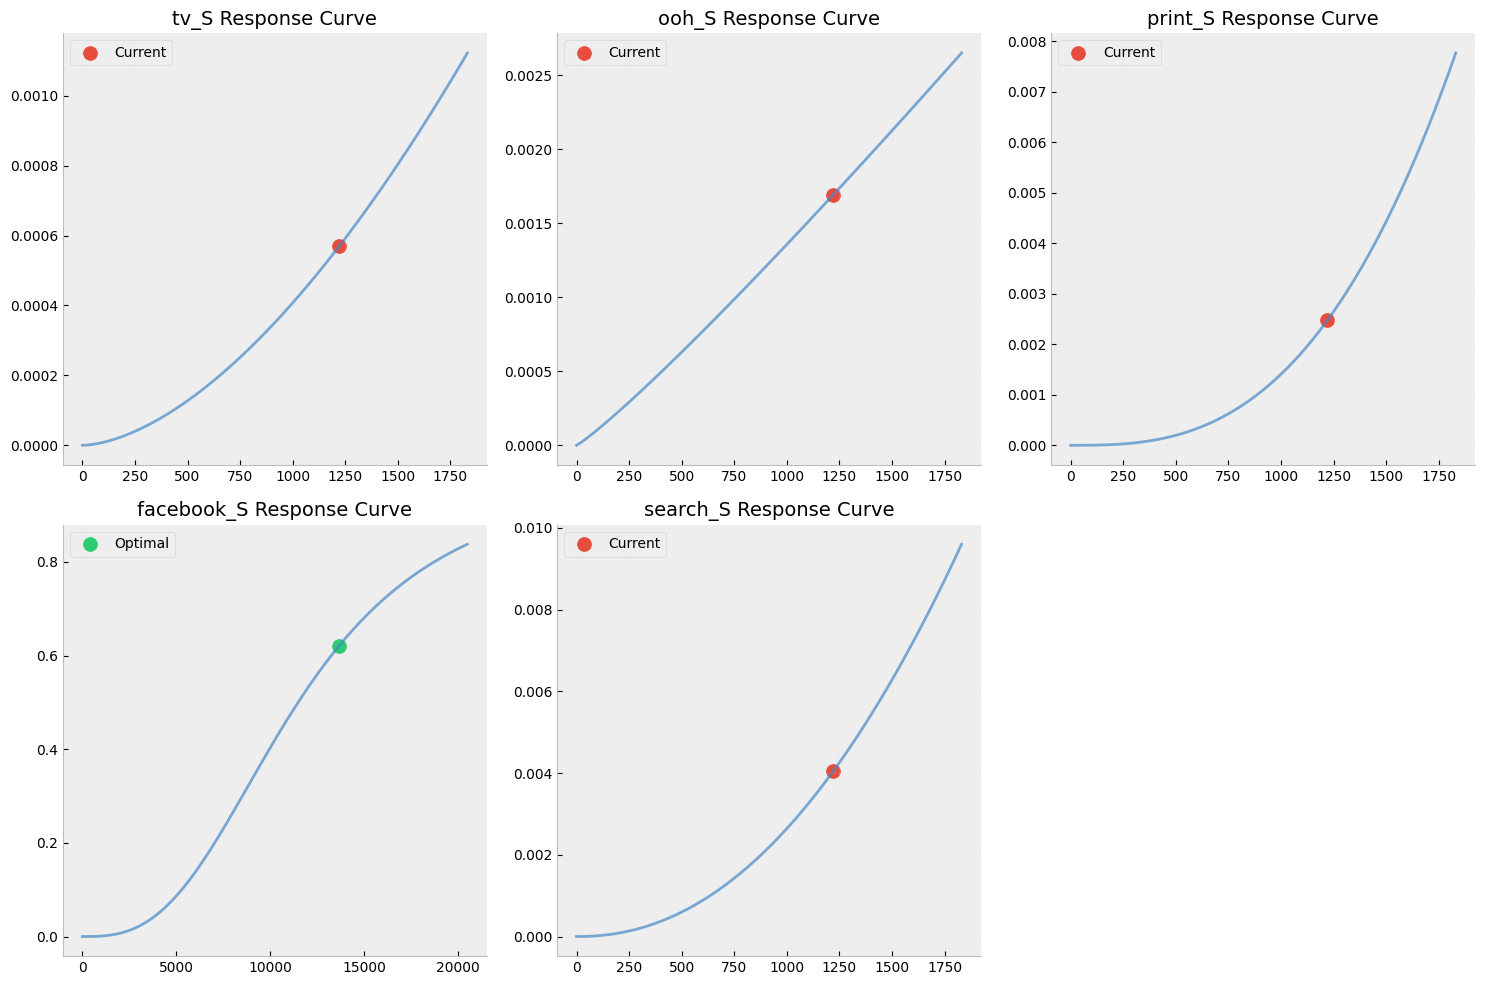

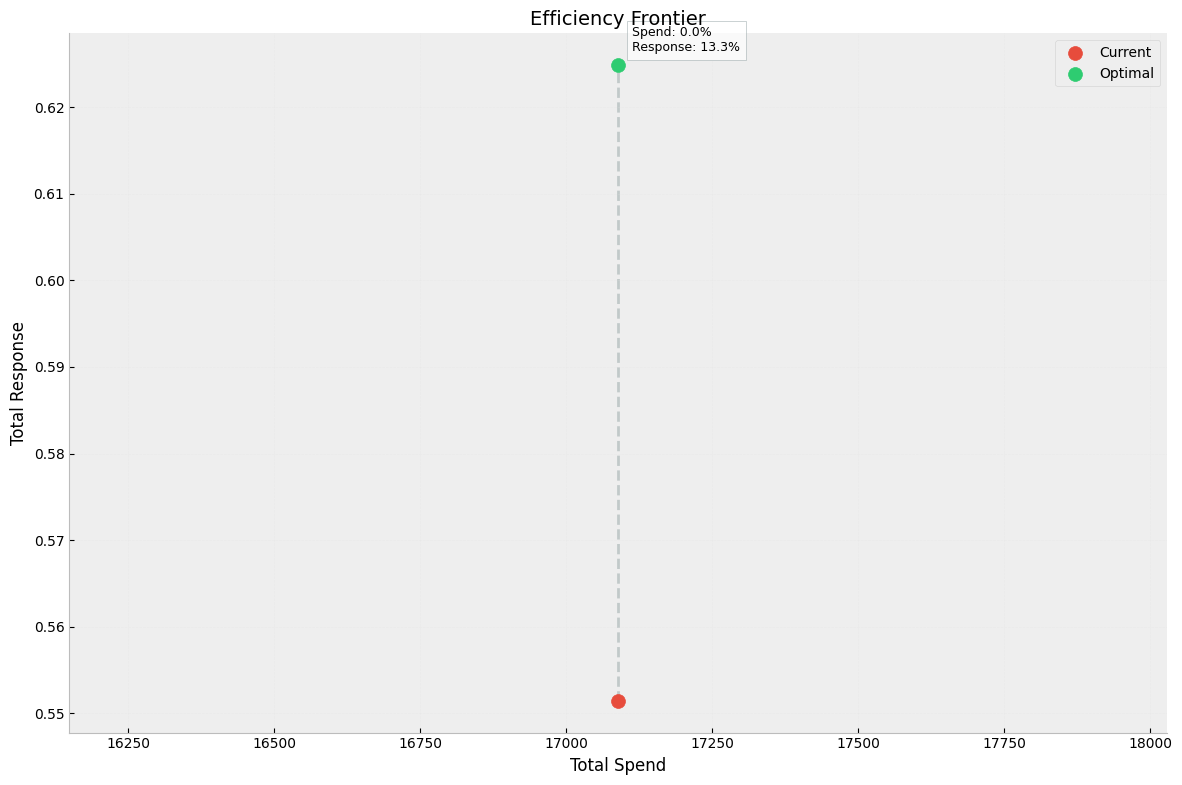

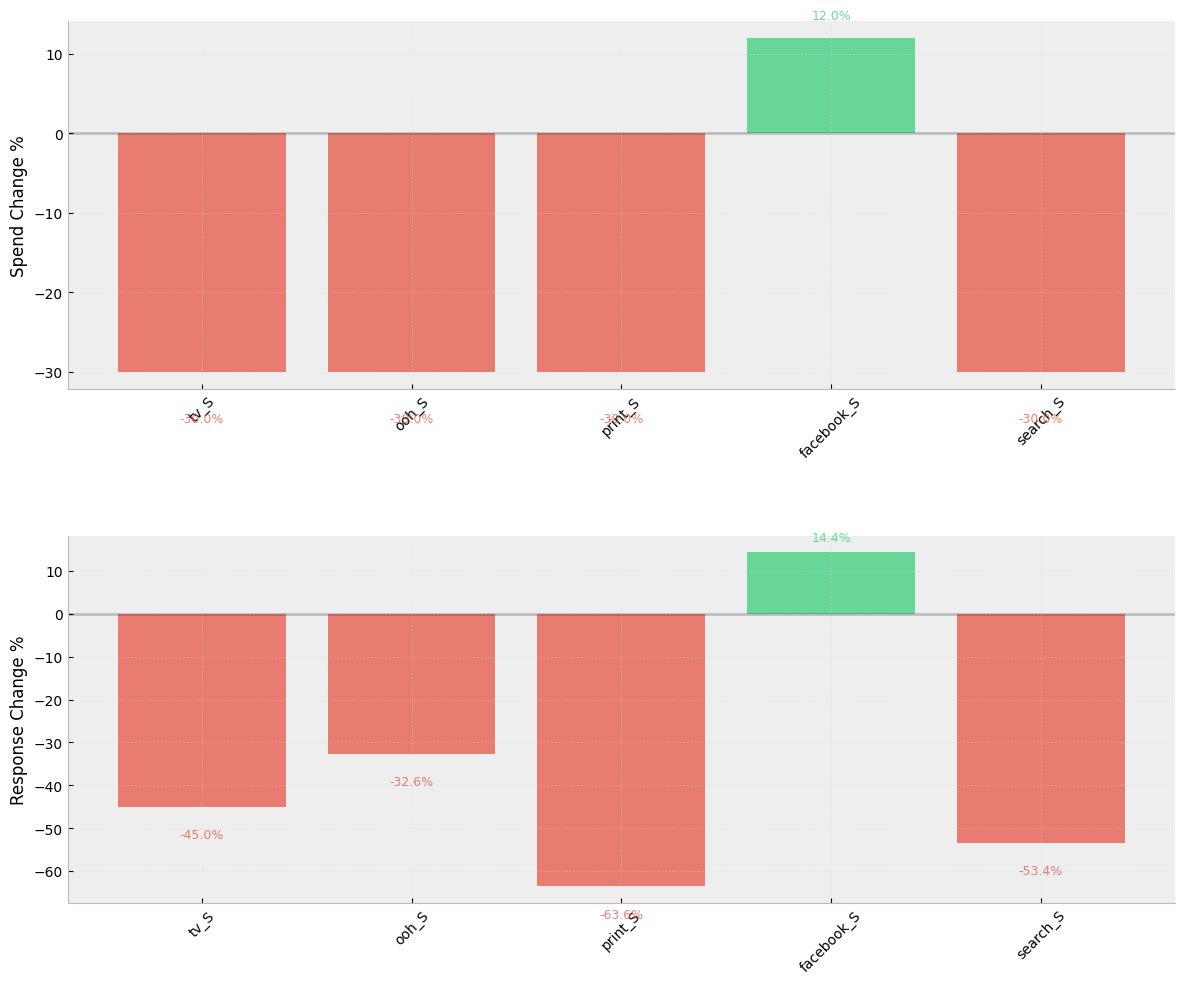

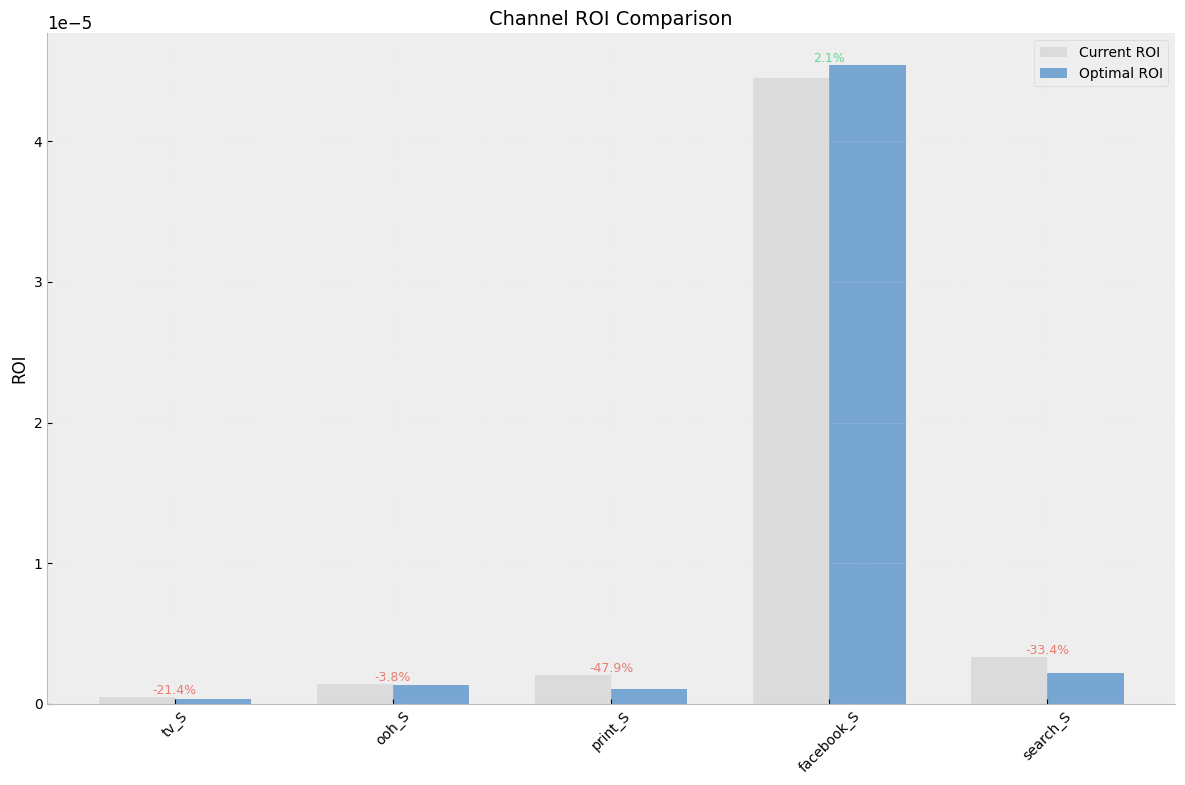


Target Efficiency Scenario Plots:
--------------------------------------------------


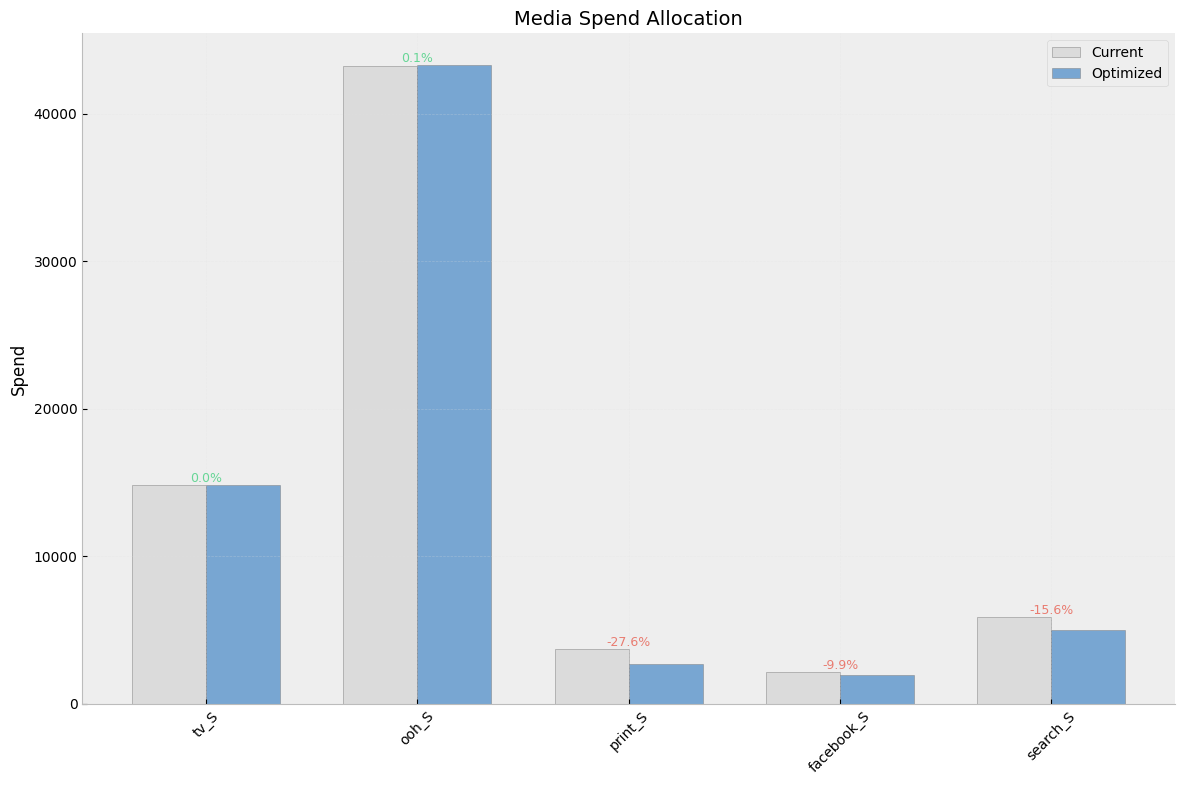

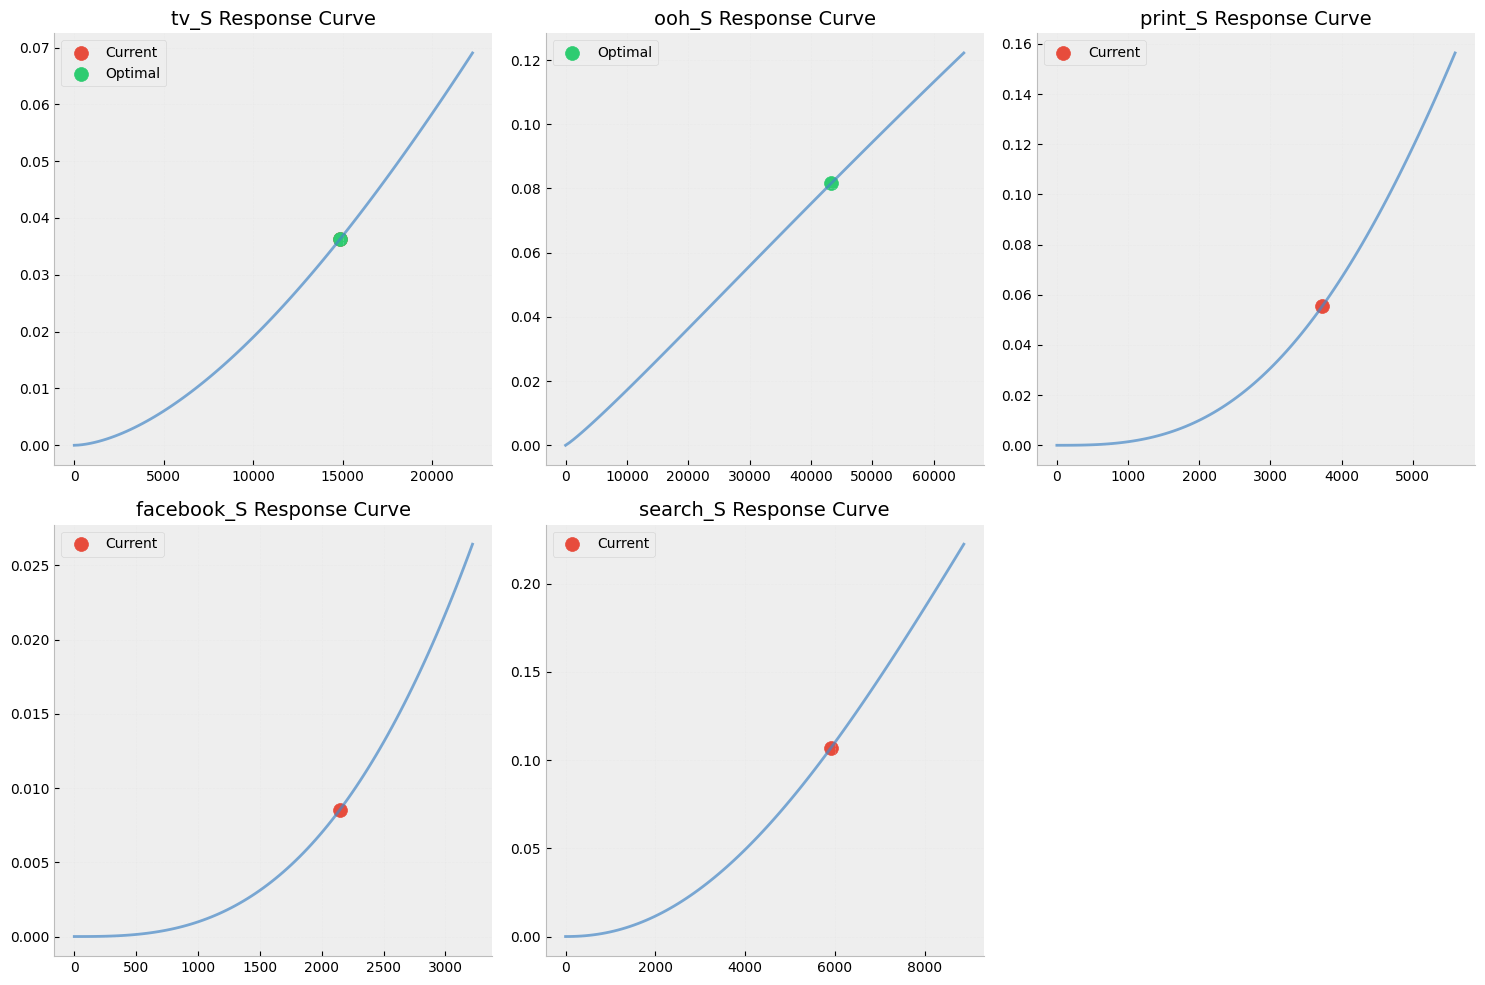

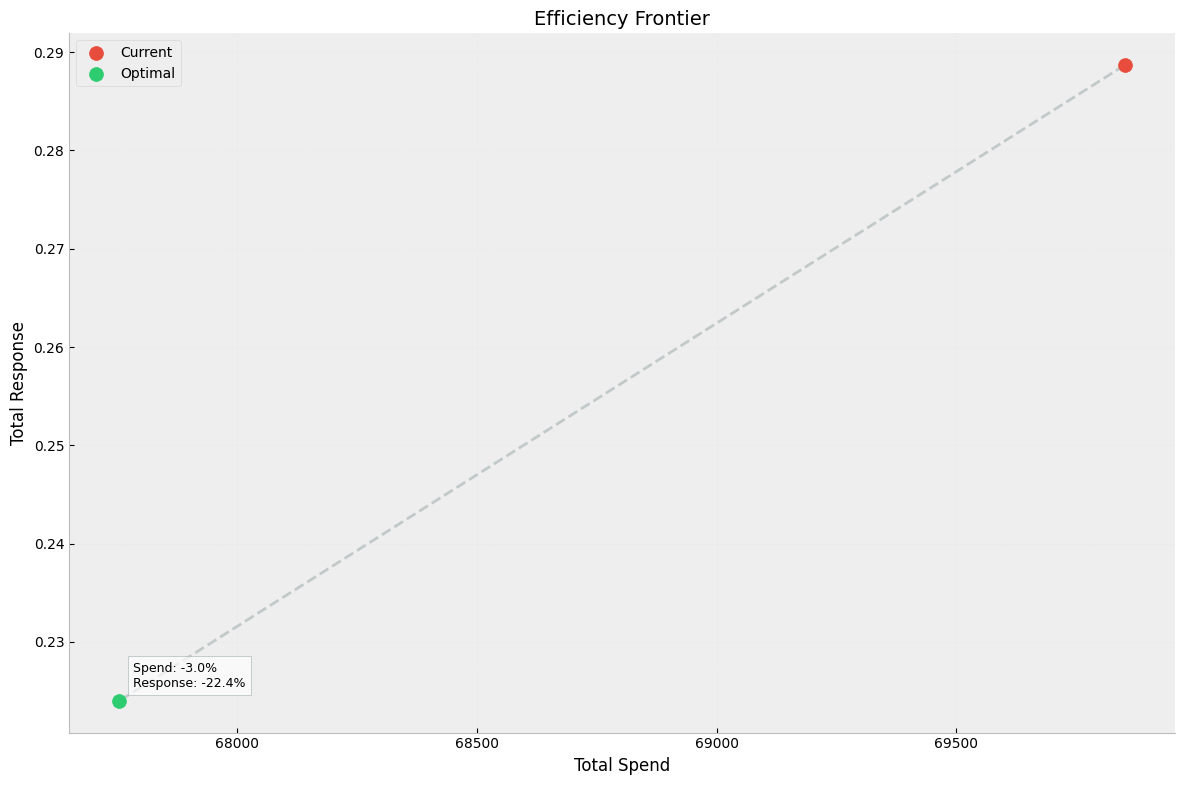

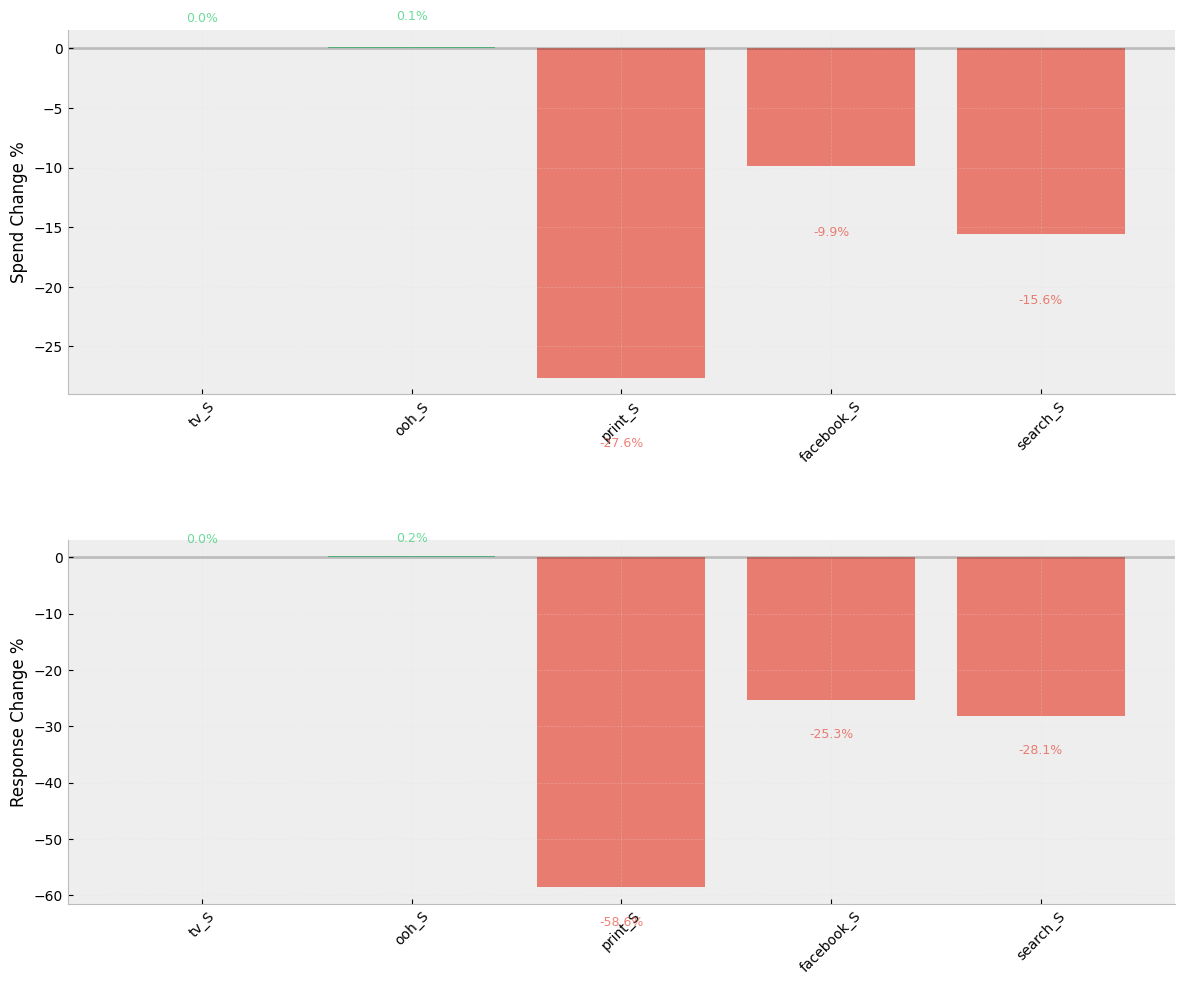

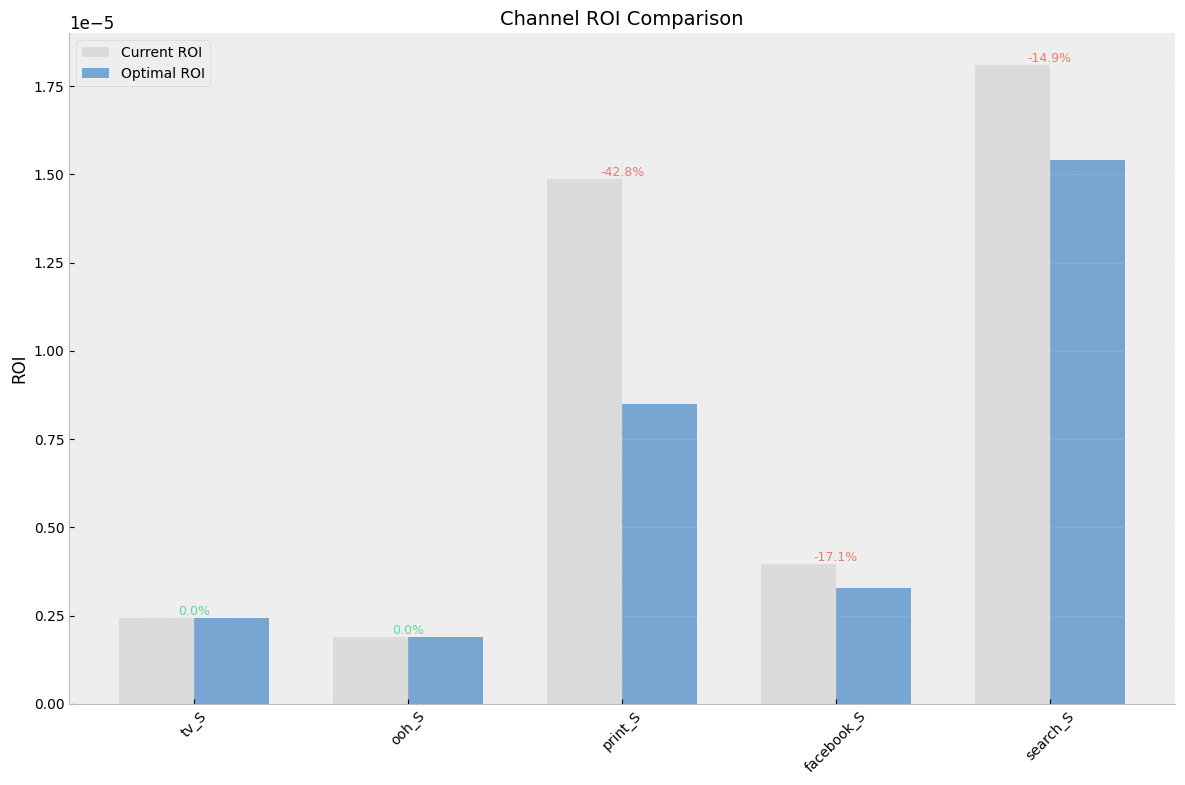

In [ ]:
# Create visualizations for each scenario
max_response_plotter = AllocationPlotter(result)
target_efficiency_plotter = AllocationPlotter(result3)

# Generate plots
max_response_plots = max_response_plotter.plot_all()
target_efficiency_plots = target_efficiency_plotter.plot_all()

# Display plots
print("Max Response Scenario Plots:")
print("-" * 50)
for plot_name, fig in max_response_plots.items():
    display(fig)


print("\nTarget Efficiency Scenario Plots:")
print("-" * 50)
for plot_name, fig in target_efficiency_plots.items():
    display(fig)